In [ ]:
pip install shap


In [ ]:
pip install shap scipy matplotlib seaborn torch numpy

[CLEAN] Found 4216 NaN/Inf values across 136 samples. Replacing with 0.
[DATA] X shape: (1000, 256); labels: (tensor([0, 1]), tensor([508, 492]))
[DEBUG] shap_iso shape: (5, 256)


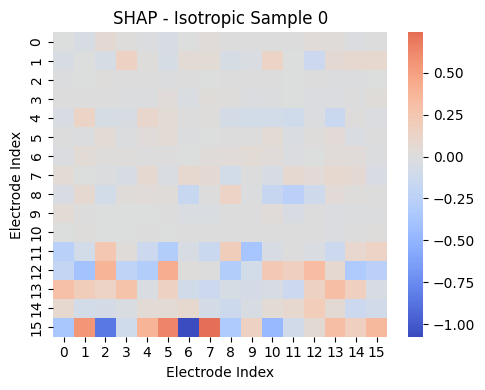

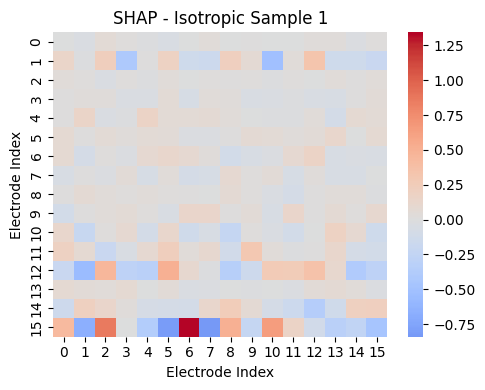

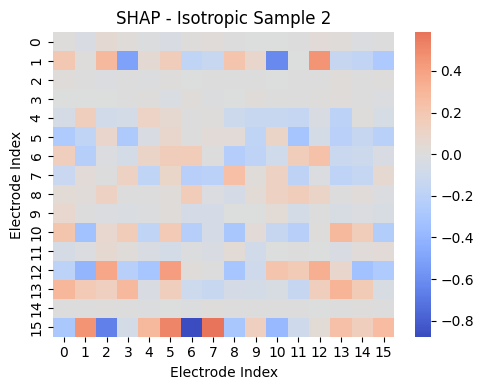

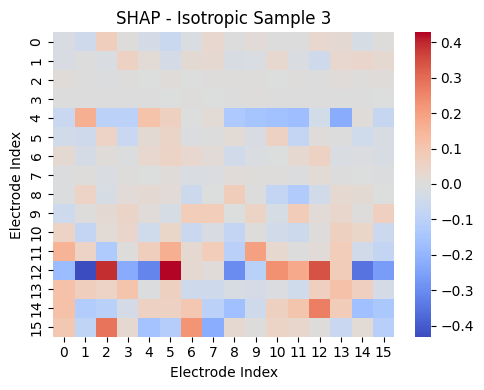

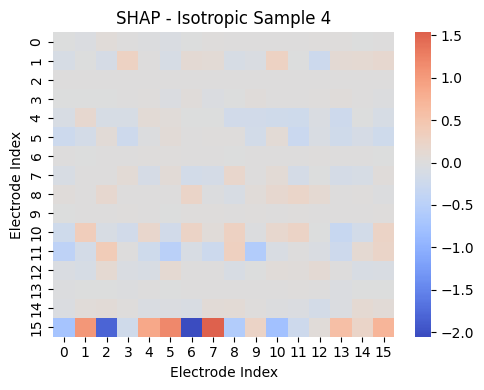

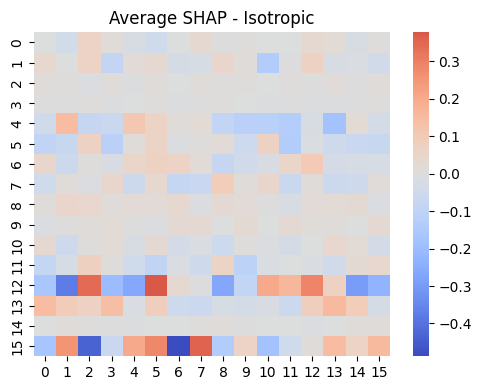

[DEBUG] shap_aniso shape: (5, 256)


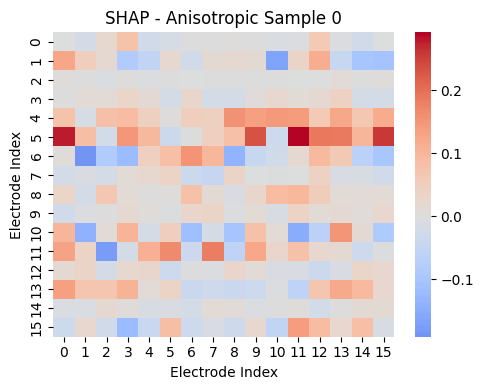

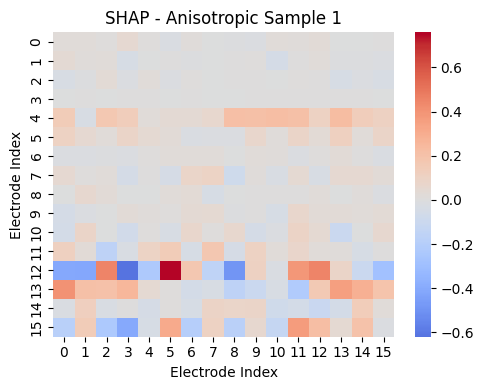

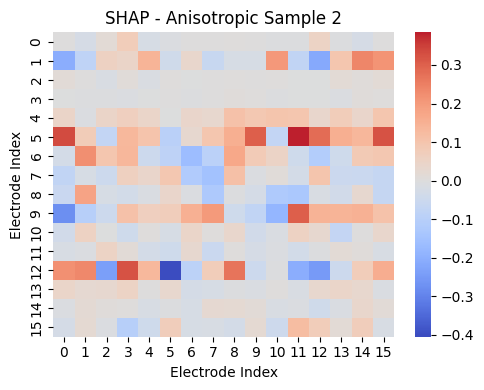

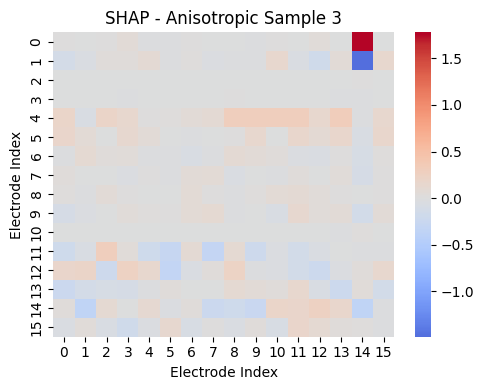

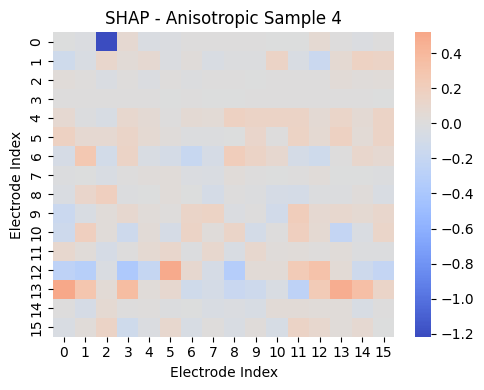

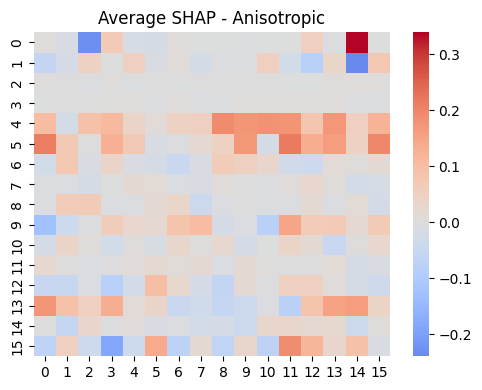

[DONE] SHAP computed for iso=5 and aniso=5 samples.


In [ ]:
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from collections import OrderedDict
import shap
import warnings

# -----------------------------
# Config
# -----------------------------
DATA_DIR   = 'DN_Matrix_Batch_new'
MODEL_PATH = 'ann_anisotropy_classifier.pth'
DEVICE     = torch.device("cpu")
np.set_printoptions(suppress=True, linewidth=120)

# -----------------------------
# Dataset
# -----------------------------
class DNMatrixDataset(Dataset):
    def __init__(self, folder):
        feats, labels, files_used = [], [], []
        files = sorted(os.listdir(folder))
        for file in files:
            if not file.endswith('.mat'):
                continue
            path = os.path.join(folder, file)
            data = scipy.io.loadmat(path)
            dn = data['DN_noisy'].flatten().astype(np.float32)
            if dn.shape[0] != 256:
                warnings.warn(f"{file}: expected 256 features, got {dn.shape[0]} — skipped.")
                continue
            label = int(data['label'].squeeze())
            feats.append(dn)
            labels.append(label)
            files_used.append(file)
        if not feats:
            raise RuntimeError(f"No valid .mat files found in {folder}")
        X = np.vstack(feats).astype(np.float32)
        y = np.array(labels, dtype=np.int64)

        # Clean NaN/Inf (log what was found)
        nan_mask = ~np.isfinite(X)
        bad_rows = np.unique(np.where(nan_mask)[0])
        if bad_rows.size > 0:
            print(f"[CLEAN] Found {nan_mask.sum()} NaN/Inf values across {bad_rows.size} samples. Replacing with 0.")
            X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels   = torch.tensor(y, dtype=torch.long)
        self.files    = files_used

    def __len__(self):  return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.labels[idx]

# -----------------------------
# Model (simple 2-layer MLP)
# -----------------------------
class AnisotropyClassifier(nn.Module):
    def __init__(self, in_features=256, hidden=16, num_classes=2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features, hidden),  # network.0
            nn.ReLU(),                       # network.1
            nn.Linear(hidden, num_classes)   # network.2
        )
    def forward(self, x): return self.network(x)

def load_remapped_model(path, device=DEVICE):
    import torch
    from collections import OrderedDict

    raw = torch.load(path, map_location="cpu")
    sd  = raw["state_dict"] if isinstance(raw, dict) and "state_dict" in raw else raw
    if not isinstance(sd, dict):
        raise RuntimeError("Unexpected checkpoint format; expected a state_dict-like dict.")

    # Remap keys "network.3.*" -> "network.2.*" (if present), otherwise keep as-is
    new_sd = OrderedDict()
    for k, v in sd.items():
        fixed_key = k.replace("network.3.", "network.2.")
        new_sd[fixed_key] = v

    # Sanity checks
    required = ["network.0.weight", "network.0.bias", "network.2.weight", "network.2.bias"]
    missing = [rk for rk in required if rk not in new_sd]
    if missing:
        # Print what keys exist to help debugging
        print("[DEBUG] Keys in checkpoint:", list(new_sd.keys()))
        raise KeyError(f"Missing expected keys after remap: {missing}")

    # Infer dims from weights
    in_features  = new_sd["network.0.weight"].shape[1]
    hidden       = new_sd["network.0.weight"].shape[0]
    out_features = new_sd["network.2.weight"].shape[0]

    # Build model and load
    model = AnisotropyClassifier(in_features, hidden, out_features).to(device)
    model.load_state_dict(new_sd, strict=True)
    model.eval()
    return model


# -----------------------------
# SHAP helpers
# -----------------------------
def plot_shap_matrix(vec256, title):
    v = np.asarray(vec256)
    if v.shape[-1] != 256:
        raise ValueError(f"Expected 256 features, got {v.shape[-1]}")
    M = v.reshape(16, 16)
    plt.figure(figsize=(5, 4))
    sns.heatmap(M, cmap='coolwarm', center=0)
    plt.title(title); plt.xlabel("Electrode Index"); plt.ylabel("Electrode Index")
    plt.tight_layout(); plt.show()

def plot_avg_heatmap(shap_2d, title):
    if shap_2d.ndim != 2 or shap_2d.shape[1] != 256:
        raise ValueError(f"Expected (N,256), got {shap_2d.shape}")
    avg = shap_2d.mean(axis=0).reshape(16,16)
    plt.figure(figsize=(5, 4))
    sns.heatmap(avg, cmap='coolwarm', center=0)
    plt.title(title); plt.tight_layout(); plt.show()

def _normalize_to_class_feature_matrix(vals, target_class, n_features=256):

    import numpy as np

    # If it's a list per-class, just pick the class
    if isinstance(vals, list):
        if not (0 <= target_class < len(vals)):
            raise ValueError(f"target_class {target_class} not in SHAP outputs with len={len(vals)}")
        arr = np.array(vals[target_class])
        if arr.ndim == 2 and arr.shape[1] == n_features:
            return arr
        if arr.ndim == 3 and arr.shape[1] == n_features:
            return arr[:, :n_features].reshape(arr.shape[0], n_features)
        raise ValueError(f"Unexpected SHAP shape for selected class: {arr.shape}")

    # Single ndarray
    arr = np.array(vals)
    if arr.ndim == 2:
        if arr.shape[1] == n_features:
            return arr
        raise ValueError(f"Got (N,{arr.shape[1]}) instead of (N,{n_features}).")
    elif arr.ndim == 3:
        # (N, 256, C)
        if arr.shape[1] == n_features:
            if target_class >= arr.shape[2]:
                raise ValueError(f"target_class {target_class} >= {arr.shape[2]}")
            return arr[:, :, target_class]
        # (N, C, 256)
        if arr.shape[2] == n_features:
            if target_class >= arr.shape[1]:
                raise ValueError(f"target_class {target_class} >= {arr.shape[1]}")
            return arr[:, target_class, :]
        # (C, N, 256)
        if arr.shape[2] == n_features and arr.shape[0] <= 10:
            if target_class >= arr.shape[0]:
                raise ValueError(f"target_class {target_class} >= {arr.shape[0]}")
            return arr[target_class, :, :]
        # (C, 256, N)
        if arr.shape[1] == n_features and arr.shape[0] <= 10:
            if target_class >= arr.shape[0]:
                raise ValueError(f"target_class {target_class} >= {arr.shape[0]}")
            return arr[target_class, :, :].T
        # (256, N, C)
        if arr.shape[0] == n_features:
            if target_class >= arr.shape[2]:
                raise ValueError(f"target_class {target_class} >= {arr.shape[2]}")
            return arr[:, :, target_class].T
        raise ValueError(f"Could not normalize SHAP array of shape {arr.shape} to (N,{n_features}).")
    else:
        raise ValueError(f"Unsupported SHAP ndim={arr.ndim} shape={arr.shape}")

def compute_shap_values_normalized(model, background, batch, target_class, prefer="deep", n_features=256):

    background = background.detach().cpu()
    batch      = batch.detach().cpu()

    try:
        expl = shap.DeepExplainer(model, background)
        vals = expl.shap_values(batch)
        return _normalize_to_class_feature_matrix(vals, target_class, n_features)
    except AssertionError:
        expl = shap.DeepExplainer(model, background)
        vals = expl.shap_values(batch, check_additivity=False)
        return _normalize_to_class_feature_matrix(vals, target_class, n_features)
    except Exception:
        expl = shap.GradientExplainer((model, background))
        vals = expl.shap_values(batch)
        return _normalize_to_class_feature_matrix(vals, target_class, n_features)

# -----------------------------
# Main
# -----------------------------
def main():
    # Load data
    dataset  = DNMatrixDataset(DATA_DIR)
    X        = dataset.features
    y        = dataset.labels
    print(f"[DATA] X shape: {tuple(X.shape)}; labels: {y.unique(return_counts=True)}")

    # Load model
    model = load_remapped_model(MODEL_PATH, device=DEVICE)

    # Background for SHAP
    bg_n = min(100, len(X))
    background = X[:bg_n]

    # Choose 5 per class if available
    iso_idx   = [i for i, lbl in enumerate(y) if int(lbl) == 0][:5]
    aniso_idx = [i for i, lbl in enumerate(y) if int(lbl) == 1][:5]
    if not iso_idx and not aniso_idx:
        raise RuntimeError("No samples for class 0 or 1 found.")

    iso_batch   = X[iso_idx]   if iso_idx   else None
    aniso_batch = X[aniso_idx] if aniso_idx else None

    # Compute + plot for class 0 (isotropic)
    if iso_batch is not None and len(iso_batch) > 0:
        shap_iso = compute_shap_values_normalized(
            model, background, iso_batch, target_class=0, prefer="deep", n_features=256
        )  # (n_iso, 256)
        print("[DEBUG] shap_iso shape:", shap_iso.shape)
        for i in range(shap_iso.shape[0]):
            plot_shap_matrix(shap_iso[i], f"SHAP - Isotropic Sample {i}")
        plot_avg_heatmap(shap_iso, "Average SHAP - Isotropic")

    # Compute + plot for class 1 (anisotropic)
    if aniso_batch is not None and len(aniso_batch) > 0:
        shap_aniso = compute_shap_values_normalized(
            model, background, aniso_batch, target_class=1, prefer="deep", n_features=256
        )
        print("[DEBUG] shap_aniso shape:", shap_aniso.shape)
        for i in range(shap_aniso.shape[0]):
            plot_shap_matrix(shap_aniso[i], f"SHAP - Anisotropic Sample {i}")
        plot_avg_heatmap(shap_aniso, "Average SHAP - Anisotropic")

    print(f"[DONE] SHAP computed for iso={len(iso_idx)} and aniso={len(aniso_idx)} samples.")

if __name__ == "__main__":
    main()


[CLEAN] Found 4216 NaN/Inf values across 136 samples. Replacing with 0.
[DATA] X shape: (1000, 256); labels: (tensor([0, 1]), tensor([508, 492]))


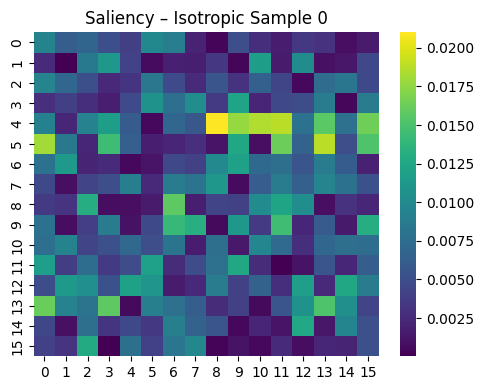

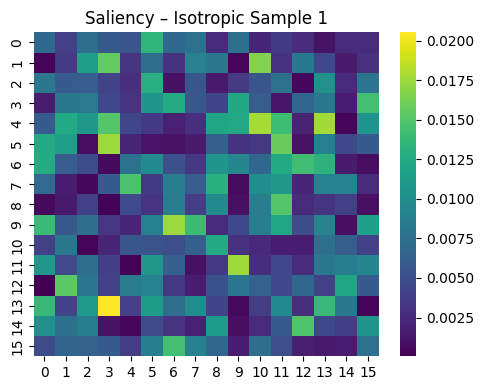

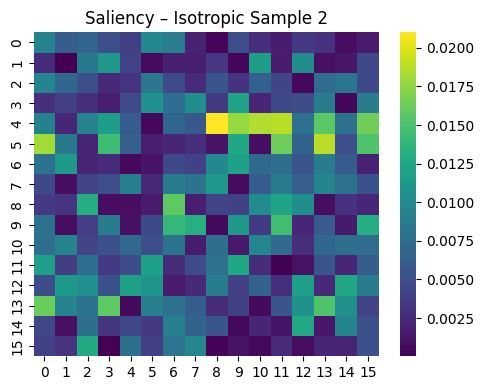

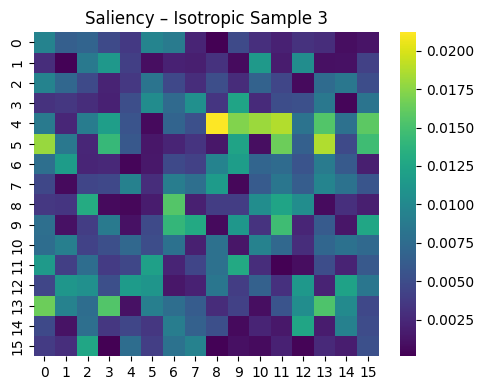

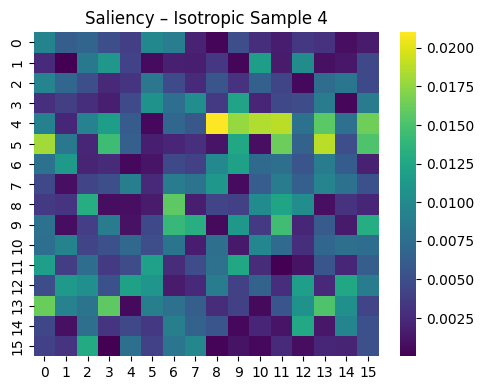

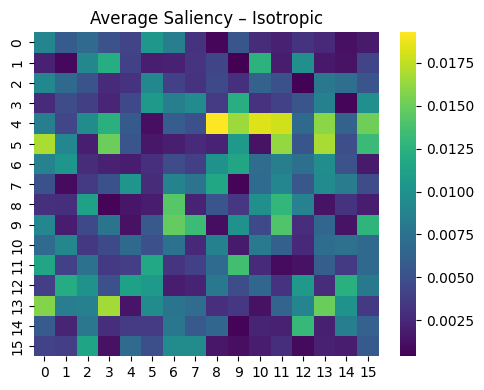

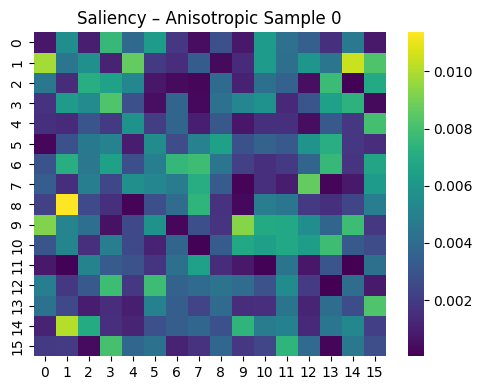

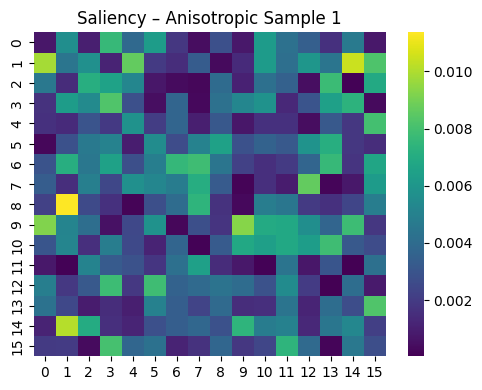

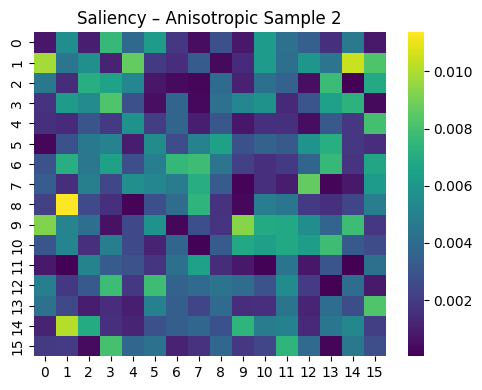

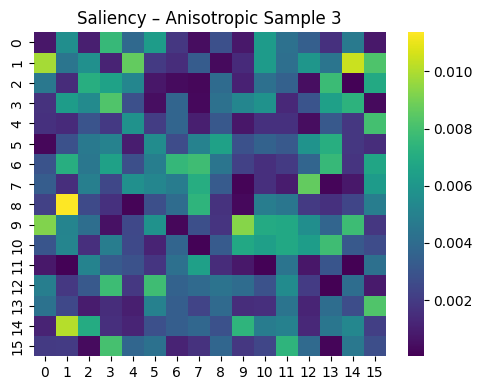

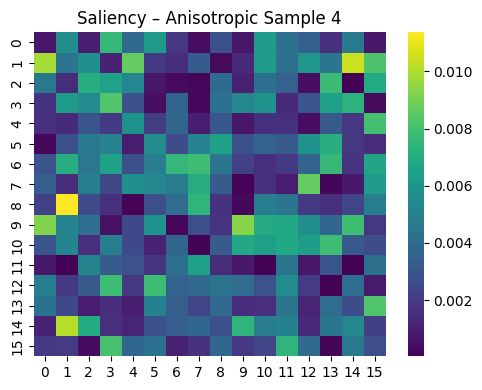

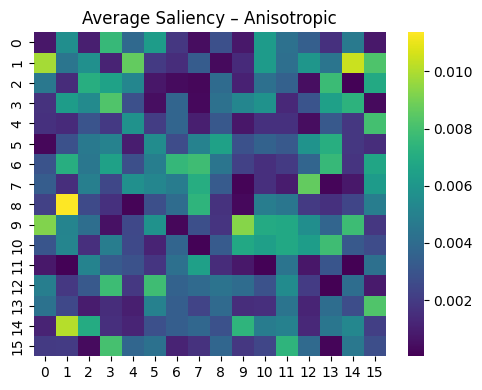

[TOP-10] Isotropic feature indices: [72, 74, 75, 80, 93, 211, 73, 91, 77, 208]
[TOP-10] Isotropic mean saliencies: [0.019279999658465385, 0.01826000027358532, 0.017890000715851784, 0.016920000314712524, 0.016839999705553055, 0.016680000349879265, 0.016540000215172768, 0.016200000420212746, 0.01600000075995922, 0.015809999778866768]
[TOP-10] Anisotropic feature indices: [129, 30, 225, 16, 153, 144, 20, 124, 51, 223]
[TOP-10] Anisotropic mean saliencies: [0.011359999887645245, 0.010459999553859234, 0.010080000385642052, 0.009850000031292439, 0.009320000186562538, 0.009209999814629555, 0.008659999817609787, 0.008659999817609787, 0.008259999565780163, 0.008229999803006649]


In [ ]:
import os
import warnings
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from collections import OrderedDict

# -----------------------------
# Setup
# -----------------------------
DATA_DIR   = 'DN_Matrix_Batch_new'
MODEL_PATH = 'ann_anisotropy_classifier.pth'
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.set_printoptions(suppress=True, linewidth=120)

# -----------------------------
# Dataset Class (robust, cleans NaN/Inf)
# -----------------------------
class DNMatrixDataset(Dataset):
    def __init__(self, folder):
        feats, labels, used = [], [], []
        files = sorted(os.listdir(folder))
        for file in files:
            if not file.endswith('.mat'):
                continue
            path = os.path.join(folder, file)
            data = scipy.io.loadmat(path)

            # Basic field checks
            if 'DN_noisy' not in data or 'label' not in data:
                warnings.warn(f"{file}: missing DN_noisy or label — skipped.")
                continue

            dn = data['DN_noisy'].flatten().astype(np.float32)
            if dn.shape[0] != 256:
                warnings.warn(f"{file}: expected 256 features, got {dn.shape[0]} — skipped.")
                continue

            label = int(np.array(data['label']).squeeze())
            feats.append(dn)
            labels.append(label)
            used.append(file)

        if not feats:
            raise RuntimeError(f"No valid .mat files found in {folder}")

        X = np.vstack(feats).astype(np.float32)
        y = np.array(labels, dtype=np.int64)

        bad_mask = ~np.isfinite(X)
        bad_rows = np.unique(np.where(bad_mask)[0])
        if bad_rows.size > 0:
            print(f"[CLEAN] Found {bad_mask.sum()} NaN/Inf values across {bad_rows.size} samples. Replacing with 0.")
            X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels   = torch.tensor(y, dtype=torch.long)
        self.files    = used

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# -----------------------------
# Model
# -----------------------------
class AnisotropyClassifier(nn.Module):
    def __init__(self, in_features=256, hidden=16, num_classes=2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features, hidden),  # network.0
            nn.ReLU(),                       # network.1
            nn.Linear(hidden, num_classes)   # network.2
        )
    def forward(self, x):
        return self.network(x)

def load_remapped_model(path, device=DEVICE):
    raw = torch.load(path, map_location="cpu")
    sd  = raw["state_dict"] if isinstance(raw, dict) and "state_dict" in raw else raw
    if not isinstance(sd, dict):
        raise RuntimeError("Unexpected checkpoint format; expected a state_dict-like dict.")

    new_sd = OrderedDict()
    for k, v in sd.items():
        new_sd[k.replace("network.3.", "network.2.")] = v

    # Sanity checks
    required = ["network.0.weight", "network.0.bias", "network.2.weight", "network.2.bias"]
    missing = [rk for rk in required if rk not in new_sd]
    if missing:
        print("[DEBUG] Keys in checkpoint:", list(new_sd.keys()))
        raise KeyError(f"Missing expected keys after remap: {missing}")

    in_features  = new_sd["network.0.weight"].shape[1]
    hidden       = new_sd["network.0.weight"].shape[0]
    out_features = new_sd["network.2.weight"].shape[0]

    model = AnisotropyClassifier(in_features, hidden, out_features).to(device)
    model.load_state_dict(new_sd, strict=True)
    model.eval()
    return model

# -----------------------------
# Saliency computation
# -----------------------------
def compute_saliency(model, input_tensor, label_idx):
    """
    input_tensor: (N, 256) on DEVICE
    label_idx:    0 for isotropic logit, 1 for anisotropic logit
    returns:      (N, 256) numpy array of |grad| wrt inputs
    """
    model.zero_grad(set_to_none=True)
    x = input_tensor.clone().detach().to(DEVICE).float().requires_grad_(True)
    with torch.enable_grad():
        outputs = model(x)
        loss = outputs[:, label_idx].sum()
        loss.backward()
        sal = x.grad.detach().abs().cpu().numpy()
    model.zero_grad(set_to_none=True)
    return sal  # (N, 256)

# -----------------------------
# Plotting helpers
# -----------------------------
def plot_saliency(vec256, title):
    v = np.asarray(vec256)
    if v.shape[-1] != 256:
        raise ValueError(f"Expected 256 features, got {v.shape[-1]}")
    M = v.reshape(16, 16)
    plt.figure(figsize=(5, 4))
    sns.heatmap(M, cmap='viridis')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_avg_saliency(saliency_2d, title):
    if saliency_2d.ndim != 2 or saliency_2d.shape[1] != 256:
        raise ValueError(f"Expected (N,256), got {saliency_2d.shape}")
    avg = saliency_2d.mean(axis=0).reshape(16, 16)
    plt.figure(figsize=(5, 4))
    sns.heatmap(avg, cmap='viridis')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# -----------------------------
# Main
# -----------------------------
def main():
    # Load data
    dataset  = DNMatrixDataset(DATA_DIR)
    features = dataset.features.to(DEVICE).float()  # (N,256)
    labels   = dataset.labels.to(DEVICE)            # (N,)
    print(f"[DATA] X shape: {tuple(features.shape)}; "
          f"labels: {torch.unique(labels, return_counts=True)}")

    # Load model (robust to key layout, matches checkpoint hidden size)
    model = load_remapped_model(MODEL_PATH, device=DEVICE)

    # Select up to 5 indices per class (or whatever is available)
    labels_cpu = labels.detach().cpu().numpy()
    iso_idx    = np.where(labels_cpu == 0)[0][:5]
    aniso_idx  = np.where(labels_cpu == 1)[0][:5]

    if iso_idx.size == 0 and aniso_idx.size == 0:
        raise RuntimeError("No samples for class 0 or 1 found.")

    iso_tensor   = features[iso_idx]   if iso_idx.size   > 0 else None
    aniso_tensor = features[aniso_idx] if aniso_idx.size > 0 else None

    # Compute saliency
    saliency_iso = compute_saliency(model, iso_tensor,   label_idx=0) if iso_tensor   is not None else None
    saliency_aniso = compute_saliency(model, aniso_tensor, label_idx=1) if aniso_tensor is not None else None

    # Plot per-sample saliency heatmaps
    if saliency_iso is not None:
        for i in range(saliency_iso.shape[0]):
            plot_saliency(saliency_iso[i], f"Saliency – Isotropic Sample {i}")
        plot_avg_saliency(saliency_iso, "Average Saliency – Isotropic")

    if saliency_aniso is not None:
        for i in range(saliency_aniso.shape[0]):
            plot_saliency(saliency_aniso[i], f"Saliency – Anisotropic Sample {i}")
        plot_avg_saliency(saliency_aniso, "Average Saliency – Anisotropic")

    # (Optional) Print top-10 sensitive features for a quick sanity check
    def topk_info(sal_2d, name, k=10):
        if sal_2d is None: return
        mean_sal = sal_2d.mean(axis=0)  # (256,)
        topk_idx = np.argsort(-mean_sal)[:k]
        print(f"[TOP-{k}] {name} feature indices:", topk_idx.tolist())
        print(f"[TOP-{k}] {name} mean saliencies:", mean_sal[topk_idx].round(5).tolist())

    topk_info(saliency_iso,   "Isotropic", k=10)
    topk_info(saliency_aniso, "Anisotropic", k=10)

if __name__ == "__main__":
    main()


[CLEAN] Found 4216 NaN/Inf values across 136 samples. Replacing with 0.
[DATA] X shape: (1000, 256); labels: (tensor([0, 1]), tensor([508, 492]))
[DEBUG] shap_iso shape: (5, 256)
[DEBUG] shap_aniso shape: (5, 256)
[DEBUG] saliency_iso shape: (5, 256)
[DEBUG] saliency_aniso shape: (5, 256)


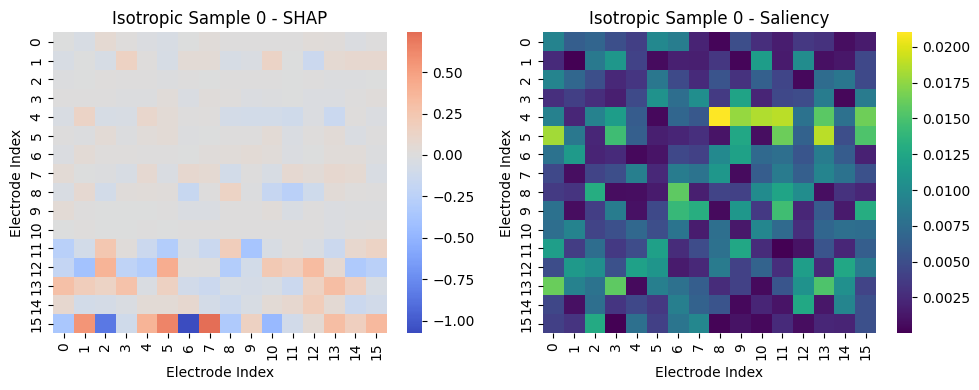

[SAVED] comparison_figs/iso_sample_0.png


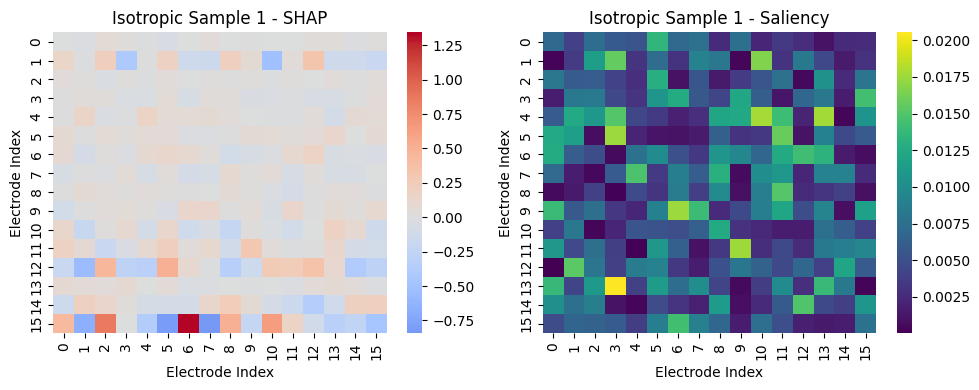

[SAVED] comparison_figs/iso_sample_1.png


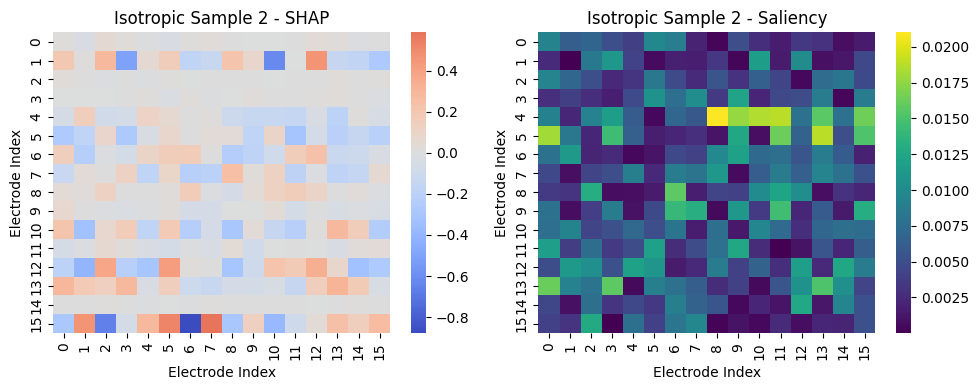

[SAVED] comparison_figs/iso_sample_2.png


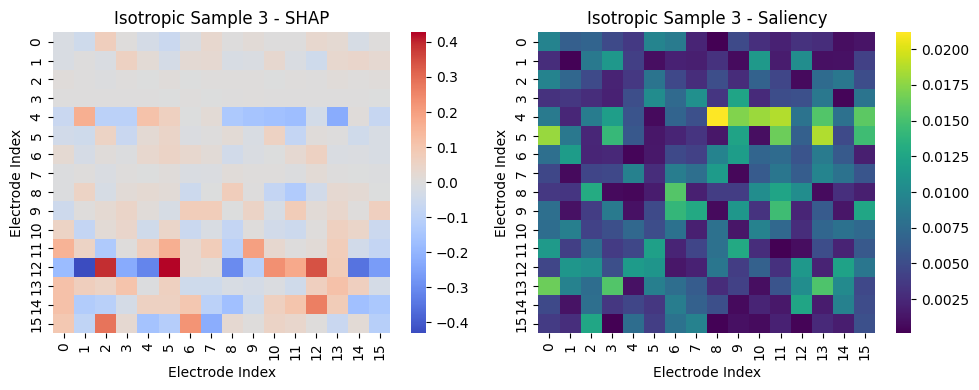

[SAVED] comparison_figs/iso_sample_3.png


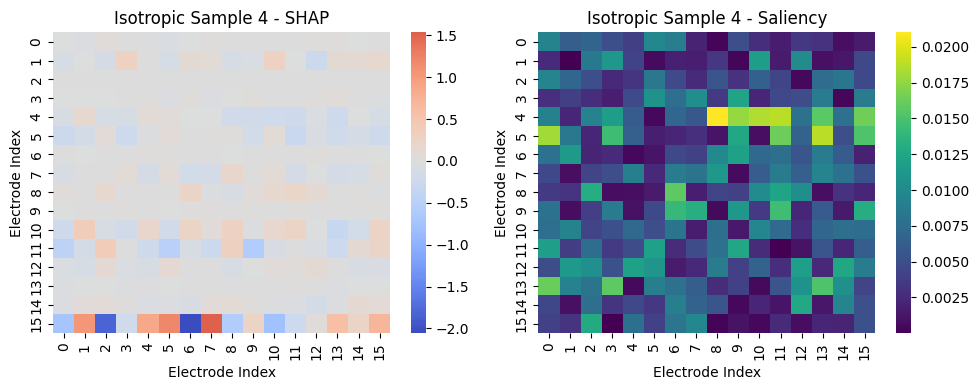

[SAVED] comparison_figs/iso_sample_4.png


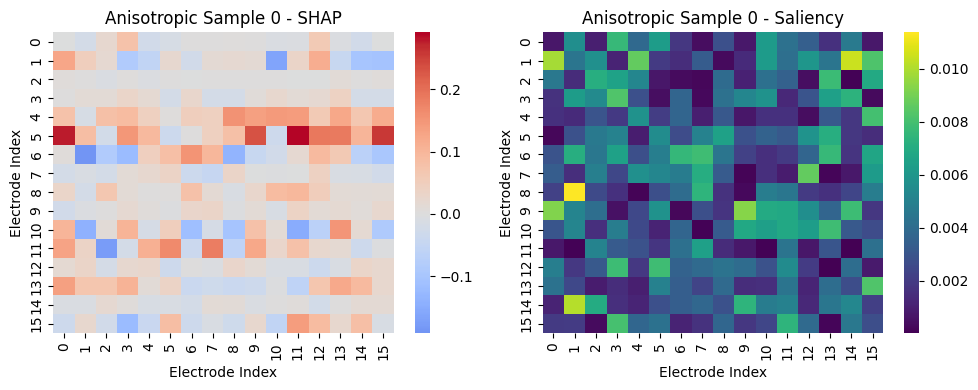

[SAVED] comparison_figs/aniso_sample_0.png


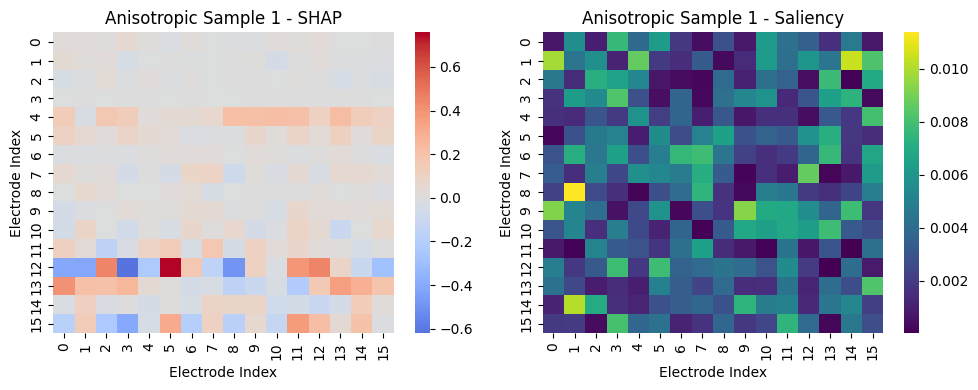

[SAVED] comparison_figs/aniso_sample_1.png


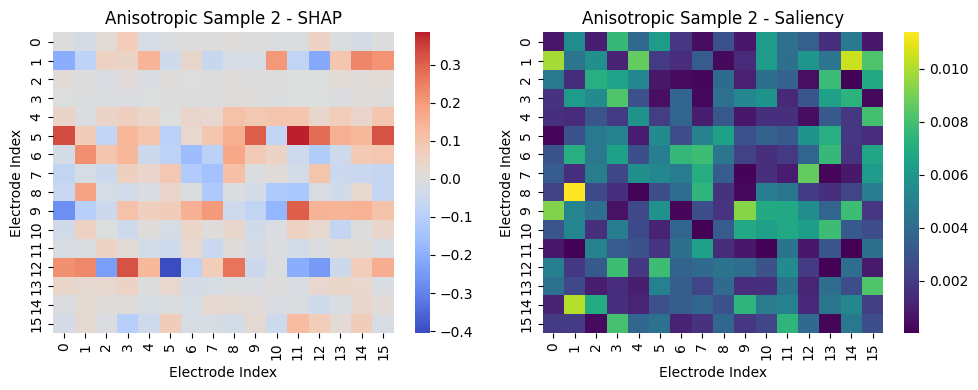

[SAVED] comparison_figs/aniso_sample_2.png


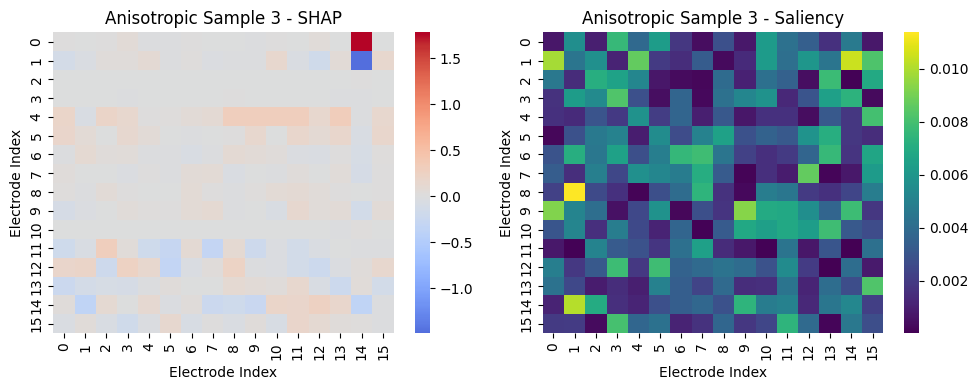

[SAVED] comparison_figs/aniso_sample_3.png


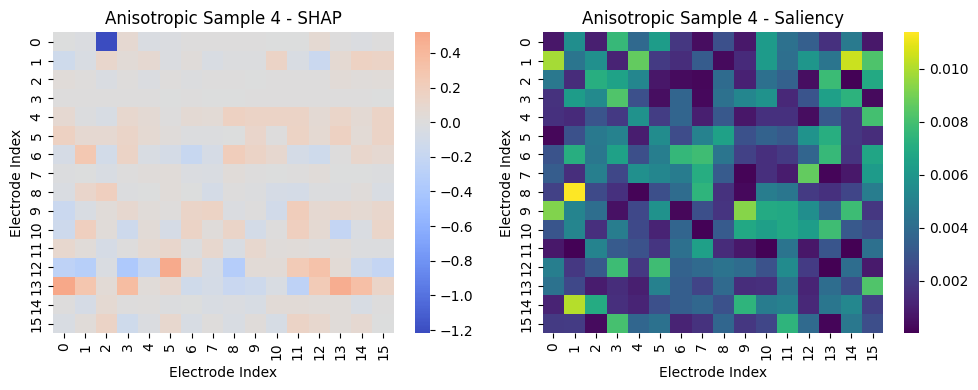

[SAVED] comparison_figs/aniso_sample_4.png


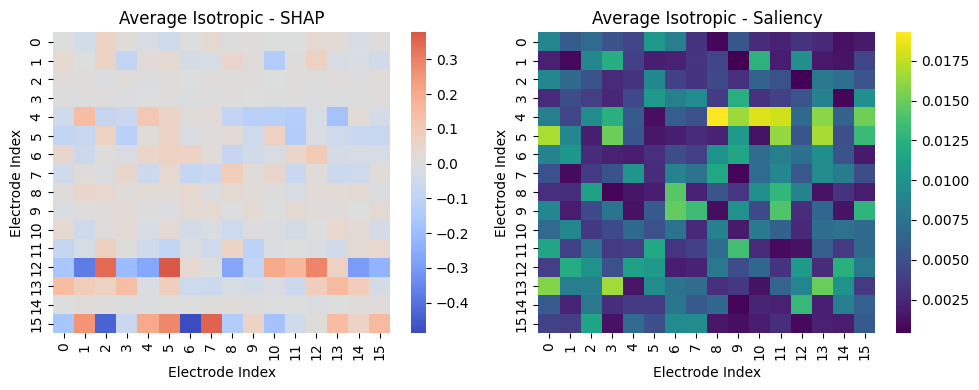

[SAVED] comparison_figs/avg_iso.png


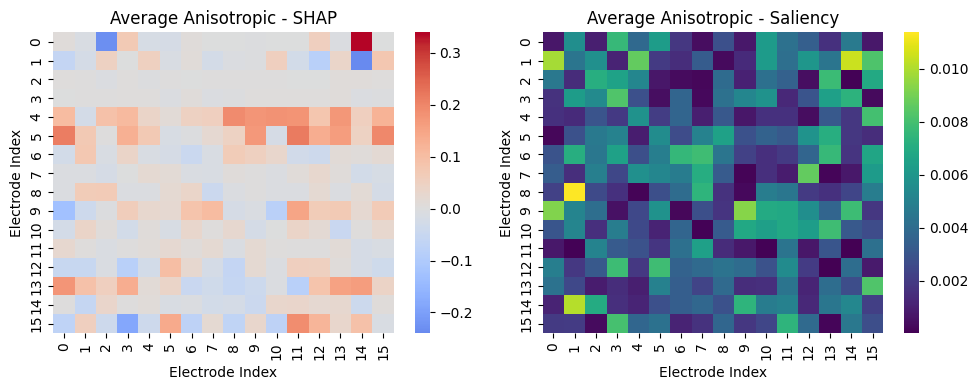

[SAVED] comparison_figs/avg_aniso.png
[DONE] Figures saved under ./comparison_figs


In [ ]:
import os
import warnings
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from collections import OrderedDict
import shap

# =============================
# CONFIG
# =============================
DATA_DIR   = 'DN_Matrix_Batch_new'
MODEL_PATH = 'ann_anisotropy_classifier.pth'
DEVICE     = torch.device("cpu")
SAVE_DIR   = "comparison_figs"
os.makedirs(SAVE_DIR, exist_ok=True)
np.set_printoptions(suppress=True, linewidth=120)

# =============================
# DATASET (robust, cleans NaN/Inf)
# =============================
class DNMatrixDataset(Dataset):
    def __init__(self, folder):
        feats, labels = [], []
        files = sorted(os.listdir(folder))
        for file in files:
            if not file.endswith('.mat'):
                continue
            path = os.path.join(folder, file)
            data = scipy.io.loadmat(path)
            if 'DN_noisy' not in data or 'label' not in data:
                warnings.warn(f"{file}: missing DN_noisy or label — skipped.")
                continue
            dn = data['DN_noisy'].flatten().astype(np.float32)
            if dn.shape[0] != 256:
                warnings.warn(f"{file}: expected 256 features, got {dn.shape[0]} — skipped.")
                continue
            label = int(np.array(data['label']).squeeze())
            feats.append(dn)
            labels.append(label)

        if not feats:
            raise RuntimeError(f"No valid .mat files found in {folder}")

        X = np.vstack(feats).astype(np.float32)
        y = np.array(labels, dtype=np.int64)

        # Clean NaN/Inf
        bad = ~np.isfinite(X)
        if bad.any():
            n_bad = bad.sum()
            n_rows = np.unique(np.where(bad)[0]).size
            print(f"[CLEAN] Found {n_bad} NaN/Inf values across {n_rows} samples. Replacing with 0.")
            X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels   = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.labels[idx]

# =============================
# MODEL (key‑remap loader)
# =============================
class AnisotropyClassifier(nn.Module):
    def __init__(self, in_features=256, hidden=16, num_classes=2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features, hidden),  # network.0
            nn.ReLU(),                       # network.1
            nn.Linear(hidden, num_classes)   # network.2
        )
    def forward(self, x): return self.network(x)

def load_remapped_model(path, device=DEVICE):
    raw = torch.load(path, map_location="cpu")
    sd  = raw["state_dict"] if isinstance(raw, dict) and "state_dict" in raw else raw
    if not isinstance(sd, dict):
        raise RuntimeError("Unexpected checkpoint format.")

    # Remap "network.3.*" -> "network.2.*" if present
    new_sd = OrderedDict((k.replace("network.3.", "network.2."), v) for k, v in sd.items())

    required = ["network.0.weight", "network.0.bias", "network.2.weight", "network.2.bias"]
    missing = [rk for rk in required if rk not in new_sd]
    if missing:
        print("[DEBUG] Keys in checkpoint:", list(new_sd.keys()))
        raise KeyError(f"Missing expected keys after remap: {missing}")

    in_features  = new_sd["network.0.weight"].shape[1]
    hidden       = new_sd["network.0.weight"].shape[0]
    out_features = new_sd["network.2.weight"].shape[0]

    model = AnisotropyClassifier(in_features, hidden, out_features).to(device)
    model.load_state_dict(new_sd, strict=True)
    model.eval()
    return model

# =============================
# SHAP helpers (robust normalization)
# =============================
def _normalize_to_class_feature_matrix(vals, target_class, n_features=256):

    import numpy as np

    if isinstance(vals, list):
        if not (0 <= target_class < len(vals)):
            raise ValueError(f"target_class {target_class} not in SHAP outputs len={len(vals)}")
        arr = np.array(vals[target_class])
        if arr.ndim == 2 and arr.shape[1] == n_features:
            return arr
        if arr.ndim == 3 and arr.shape[1] == n_features:
            return arr[:, :n_features].reshape(arr.shape[0], n_features)
        raise ValueError(f"Unexpected SHAP shape for selected class: {arr.shape}")

    arr = np.array(vals)
    if arr.ndim == 2:
        if arr.shape[1] == n_features:
            return arr
        raise ValueError(f"Got (N,{arr.shape[1]}) instead of (N,{n_features}).")
    elif arr.ndim == 3:
        if arr.shape[1] == n_features:  # (N, 256, C)
            if target_class >= arr.shape[2]:
                raise ValueError(f"target_class {target_class} >= {arr.shape[2]}")
            return arr[:, :, target_class]
        if arr.shape[2] == n_features:  # (N, C, 256)
            if target_class >= arr.shape[1]:
                raise ValueError(f"target_class {target_class} >= {arr.shape[1]}")
            return arr[:, target_class, :]
        if arr.shape[2] == n_features and arr.shape[0] <= 10:  # (C, N, 256)
            if target_class >= arr.shape[0]:
                raise ValueError(f"target_class {target_class} >= {arr.shape[0]}")
            return arr[target_class, :, :]
        if arr.shape[1] == n_features and arr.shape[0] <= 10:  # (C, 256, N)
            if target_class >= arr.shape[0]:
                raise ValueError(f"target_class {target_class} >= {arr.shape[0]}")
            return arr[target_class, :, :].T
        if arr.shape[0] == n_features:  # (256, N, C)
            if target_class >= arr.shape[2]:
                raise ValueError(f"target_class {target_class} >= {arr.shape[2]}")
            return arr[:, :, target_class].T
        raise ValueError(f"Could not normalize SHAP shape {arr.shape} to (N,{n_features}).")
    else:
        raise ValueError(f"Unsupported SHAP ndim={arr.ndim} shape={arr.shape}")

def compute_shap_values_normalized(model, background, batch, target_class, prefer="deep", n_features=256):

    background = background.detach().cpu()
    batch      = batch.detach().cpu()

    try:
        expl = shap.DeepExplainer(model, background)
        vals = expl.shap_values(batch)
        return _normalize_to_class_feature_matrix(vals, target_class, n_features)
    except AssertionError:
        expl = shap.DeepExplainer(model, background)
        vals = expl.shap_values(batch, check_additivity=False)
        return _normalize_to_class_feature_matrix(vals, target_class, n_features)
    except Exception:
        expl = shap.GradientExplainer((model, background))
        vals = expl.shap_values(batch)
        return _normalize_to_class_feature_matrix(vals, target_class, n_features)

# =============================
# Saliency
# =============================
def compute_saliency(model, input_tensor, label_idx):

    model.zero_grad(set_to_none=True)
    x = input_tensor.clone().detach().to(DEVICE).float().requires_grad_(True)
    with torch.enable_grad():
        outputs = model(x)              # (N, 2)
        loss = outputs[:, label_idx].sum()
        loss.backward()
        sal = x.grad.detach().abs().cpu().numpy()
    model.zero_grad(set_to_none=True)
    return sal

# =============================
# Plotting
# =============================
def _to_vec256(item, prefer_class=None):
    a = np.array(item)
    if a.ndim == 1 and a.shape[0] == 256:       return a
    if a.ndim == 2 and a.shape == (16, 16):     return a.reshape(256)
    if a.ndim == 2 and a.shape[0] == 256:       # (256, C)
        if prefer_class is None: raise ValueError("prefer_class required for (256, C).")
        return a[:, prefer_class]
    if a.ndim == 2 and a.shape[1] == 256:       # (C, 256)
        if prefer_class is None: raise ValueError("prefer_class required for (C, 256).")
        return a[prefer_class, :]
    raise ValueError(f"Unsupported per-sample shape for 256-vector conversion: {a.shape}")

def plot_shap_vs_saliency(shap_item, sal_item, title, out_name, prefer_class=None, show=True):
    s256 = _to_vec256(shap_item, prefer_class=prefer_class)
    g256 = _to_vec256(sal_item,  prefer_class=prefer_class)
    s_map = s256.reshape(16, 16); g_map = g256.reshape(16, 16)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(s_map, cmap='coolwarm', center=0, ax=axs[0]); axs[0].set_title(f"{title} - SHAP")
    sns.heatmap(g_map, cmap='viridis', ax=axs[1]);            axs[1].set_title(f"{title} - Saliency")
    for ax in axs:
        ax.set_xlabel("Electrode Index"); ax.set_ylabel("Electrode Index")
    plt.tight_layout()
    out_path = os.path.join(SAVE_DIR, out_name)
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    if show: plt.show()
    plt.close(fig)
    print(f"[SAVED] {out_path}")

# =============================
# MAIN
# =============================
def main():
    # Load data
    dataset  = DNMatrixDataset(DATA_DIR)
    X        = dataset.features.to(DEVICE).float()   # (N,256)
    y        = dataset.labels.to(DEVICE)             # (N,)
    print(f"[DATA] X shape: {tuple(X.shape)}; labels: {torch.unique(y, return_counts=True)}")

    # Load model
    model = load_remapped_model(MODEL_PATH, device=DEVICE)

    # Background for SHAP
    bg_n = min(100, len(X))
    background = X[:bg_n]

    # Select up to 5 per class
    y_np = y.cpu().numpy()
    iso_idx   = np.where(y_np == 0)[0][:5]
    aniso_idx = np.where(y_np == 1)[0][:5]

    if iso_idx.size == 0 and aniso_idx.size == 0:
        raise RuntimeError("No samples for class 0 or 1 found.")

    iso_batch   = X[iso_idx]   if iso_idx.size   > 0 else None
    aniso_batch = X[aniso_idx] if aniso_idx.size > 0 else None

    # --- SHAP ---
    shap_iso   = compute_shap_values_normalized(model, background, iso_batch,   target_class=0) if iso_batch   is not None else None
    shap_aniso = compute_shap_values_normalized(model, background, aniso_batch, target_class=1) if aniso_batch is not None else None
    if shap_iso is not None:   print("[DEBUG] shap_iso shape:", shap_iso.shape)
    if shap_aniso is not None: print("[DEBUG] shap_aniso shape:", shap_aniso.shape)

    # --- Saliency ---
    saliency_iso   = compute_saliency(model, iso_batch,   label_idx=0) if iso_batch   is not None else None
    saliency_aniso = compute_saliency(model, aniso_batch, label_idx=1) if aniso_batch is not None else None
    if saliency_iso is not None:   print("[DEBUG] saliency_iso shape:", saliency_iso.shape)
    if saliency_aniso is not None: print("[DEBUG] saliency_aniso shape:", saliency_aniso.shape)

    # --- Per-sample comparisons ---
    if shap_iso is not None and saliency_iso is not None:
        n = min(5, shap_iso.shape[0], saliency_iso.shape[0])
        for i in range(n):
            plot_shap_vs_saliency(shap_iso[i], saliency_iso[i], f"Isotropic Sample {i}", f"iso_sample_{i}.png")

    if shap_aniso is not None and saliency_aniso is not None:
        n = min(5, shap_aniso.shape[0], saliency_aniso.shape[0])
        for i in range(n):
            plot_shap_vs_saliency(shap_aniso[i], saliency_aniso[i], f"Anisotropic Sample {i}", f"aniso_sample_{i}.png")

    # --- Averages ---
    def _avg256(arr2d): return arr2d.mean(axis=0)  # (256,)
    if shap_iso is not None and saliency_iso is not None and shap_iso.shape[0] > 0 and saliency_iso.shape[0] > 0:
        plot_shap_vs_saliency(_avg256(shap_iso), _avg256(saliency_iso), "Average Isotropic", "avg_iso.png")

    if shap_aniso is not None and saliency_aniso is not None and shap_aniso.shape[0] > 0 and saliency_aniso.shape[0] > 0:
        plot_shap_vs_saliency(_avg256(shap_aniso), _avg256(saliency_aniso), "Average Anisotropic", "avg_aniso.png")

    print(f"[DONE] Figures saved under ./{SAVE_DIR}")

if __name__ == "__main__":
    main()
